# RCES Final Project

In [1]:
# load packages
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']= (12, 6)
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")

### Data - Sea Surface Temperature

In [2]:
# sea surface temperature
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/.Diagnostic/.surface/.temp/dods'
sst = xr.open_dataset(url, decode_times=False)
true_time = (pd.date_range(start='1949-01-01', periods=len(sst['T']), freq='MS'))
#MS: month start frequency
sst['T'] = true_time
sst = sst.rename({'T': 'time'})
sst = sst.load()

# rename coordinates
sst = sst.rename({'X': 'lon', 'Y': 'lat', 'temp': 'SST'})

sst

<xarray.Dataset>
Dimensions:  (lat: 94, lon: 192, time: 886)
Coordinates:
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1949-01-01 1949-02-01 ... 2022-10-01
Data variables:
    SST      (time, lat, lon) float32 231.6 231.6 231.6 ... 230.8 230.7 230.5
Attributes:
    Conventions:  IRIDL

### Seasonal Mean (unweighted)

In [44]:
# sst
sst_smean = sst.resample(time='QS-DEC').mean(skipna=True, keep_attrs=True)
sst_smean

<xarray.Dataset>
Dimensions:  (time: 296, lat: 94, lon: 192)
Coordinates:
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1948-12-01 1949-03-01 ... 2022-09-01
Data variables:
    SST      (time, lat, lon) float32 236.1 236.1 236.0 ... 222.9 222.7 222.5
Attributes:
    Conventions:  IRIDL

### Climatology & Anomaly

In [54]:
# climatology
sst_seasons = xr.Dataset(dict(climatology = sst_smean.SST.groupby('time.season').mean(dim='time', skipna=True)))
sst_seasons.climatology.attrs["units"] = "Kelvin"
sst_seasons.climatology.attrs["long_name"] = "SST (Seasonal) Climatology"

# anomaly
sst_seasons = sst_seasons.assign(anomaly = sst_smean.SST.groupby('time.season') - sst_seasons.climatology)
sst_seasons.anomaly.attrs["units"] = "Kelvin"
sst_seasons.anomaly.attrs["long_name"] = "SST (Seasonal) Anomalies"
sst_seasons

<xarray.Dataset>
Dimensions:      (lat: 94, lon: 192, season: 4, time: 296)
Coordinates:
  * lat          (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon          (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * time         (time) datetime64[ns] 1948-12-01 1949-03-01 ... 2022-09-01
Data variables:
    climatology  (season, lat, lon) float32 239.7 239.7 239.6 ... 226.7 226.5
    anomaly      (time, lat, lon) float32 -3.585 -3.591 -3.601 ... -3.954 -3.997

##### Climatology (by season)

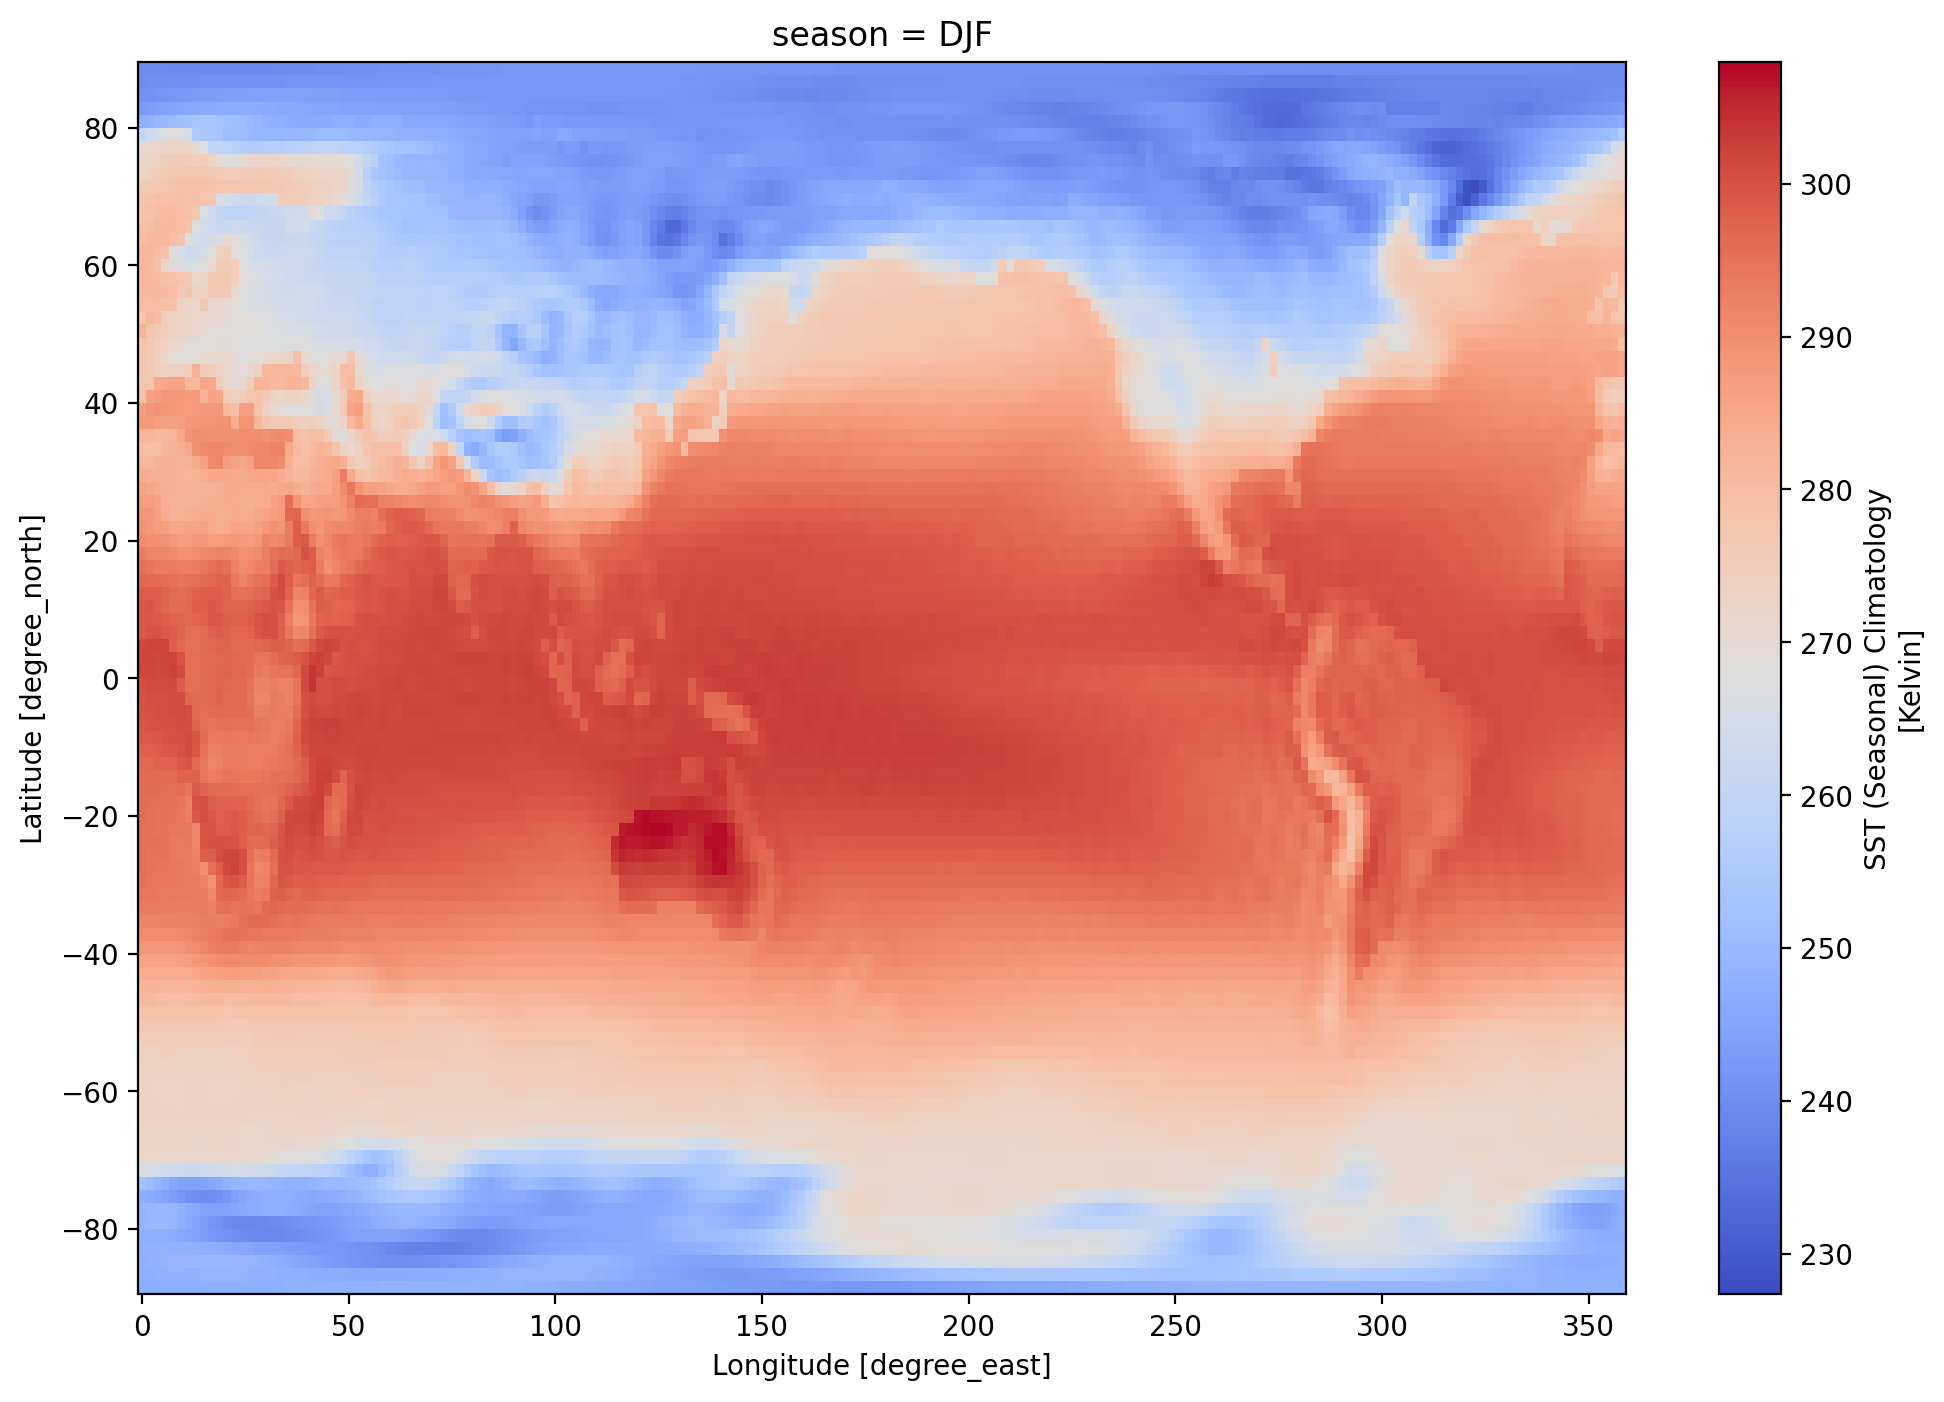

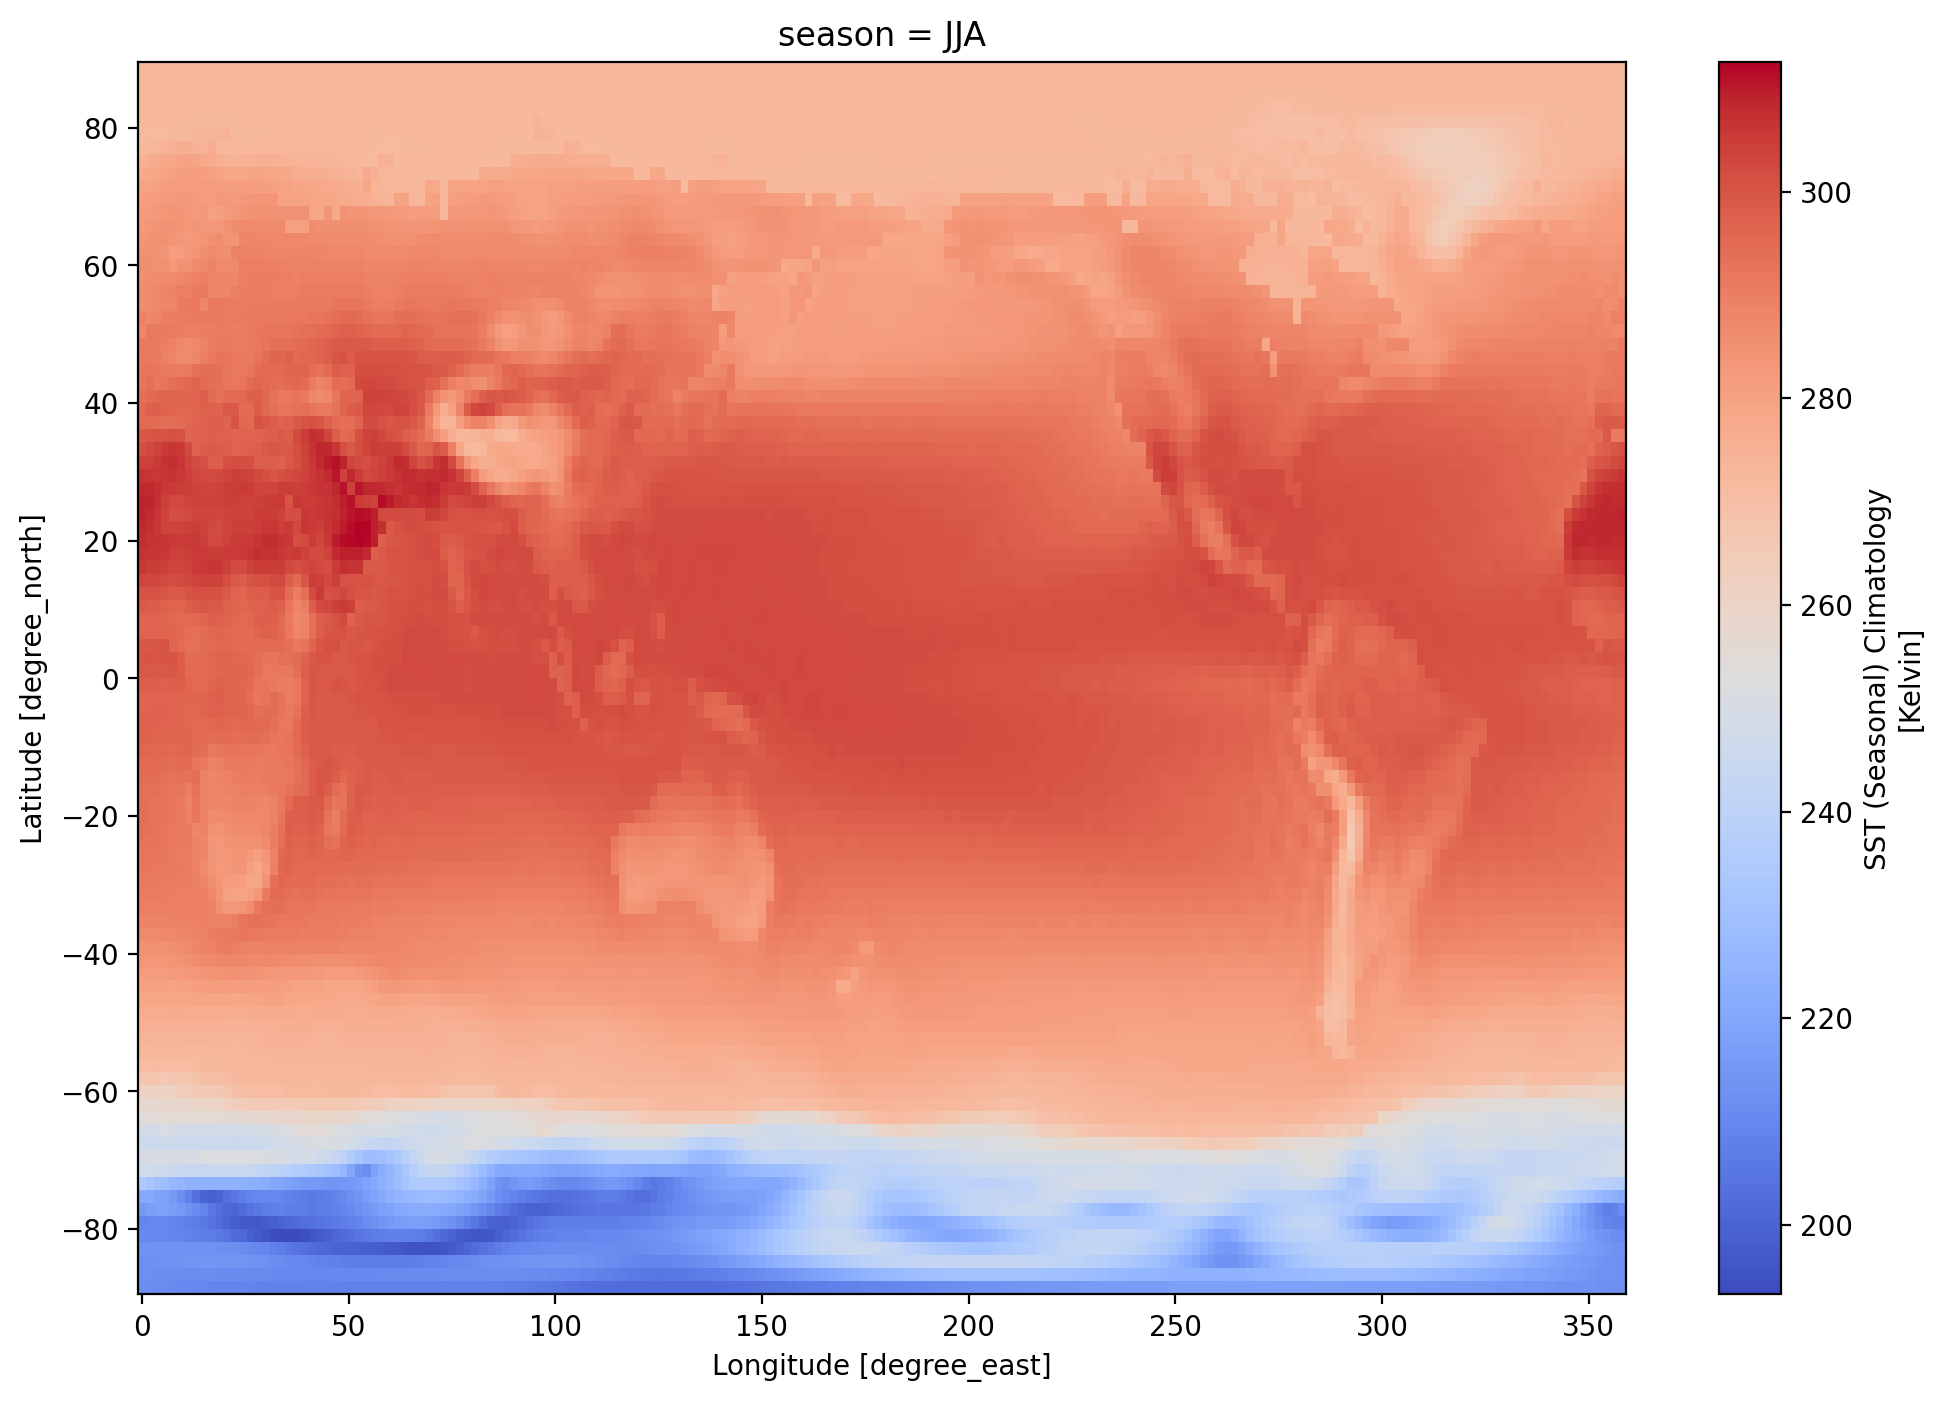

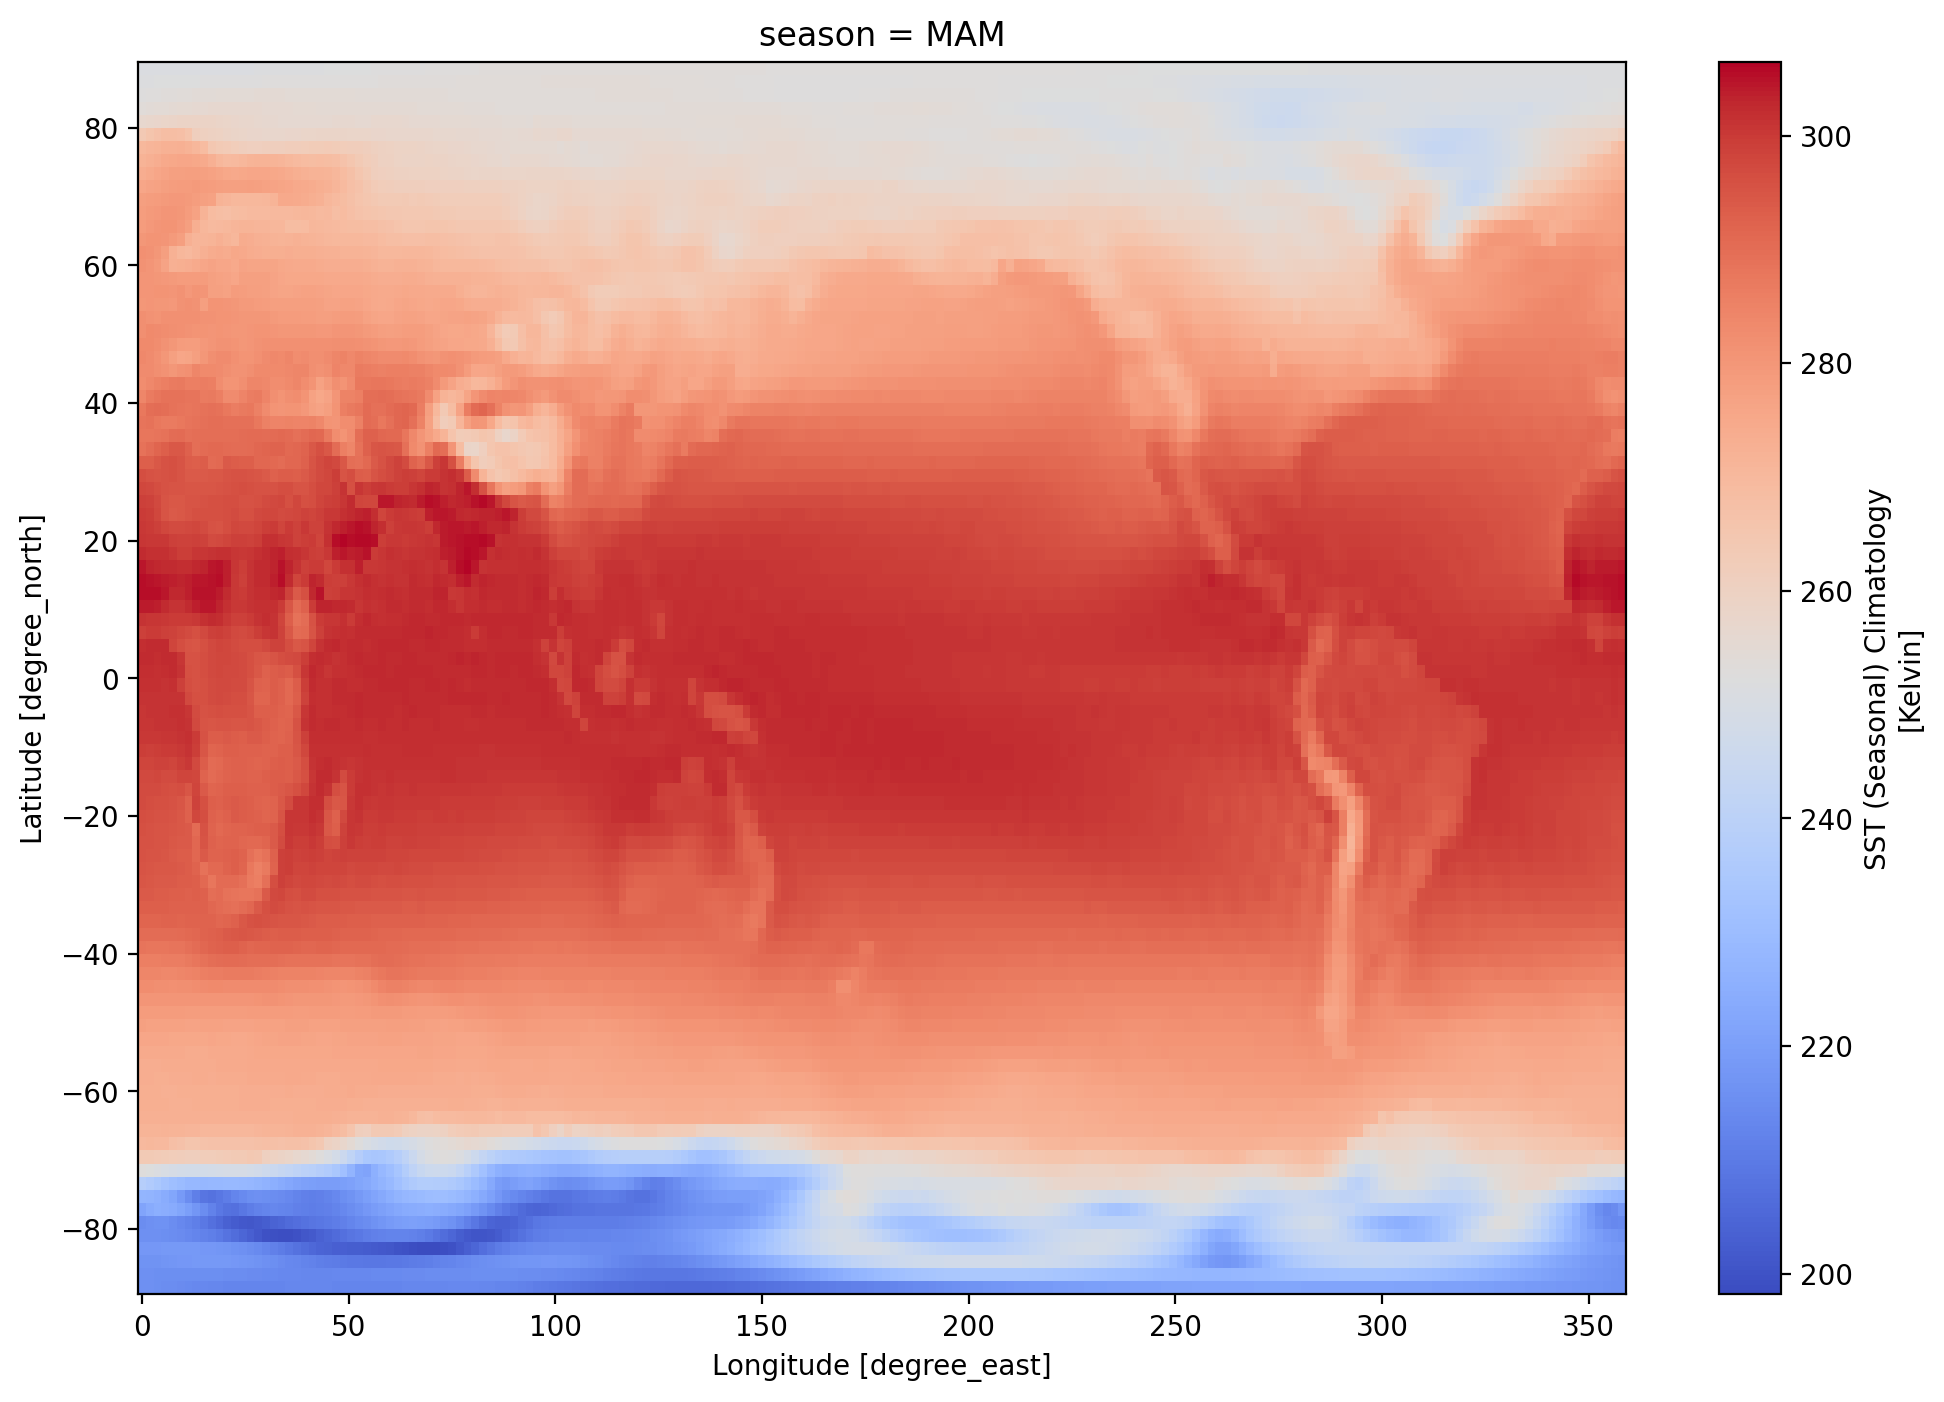

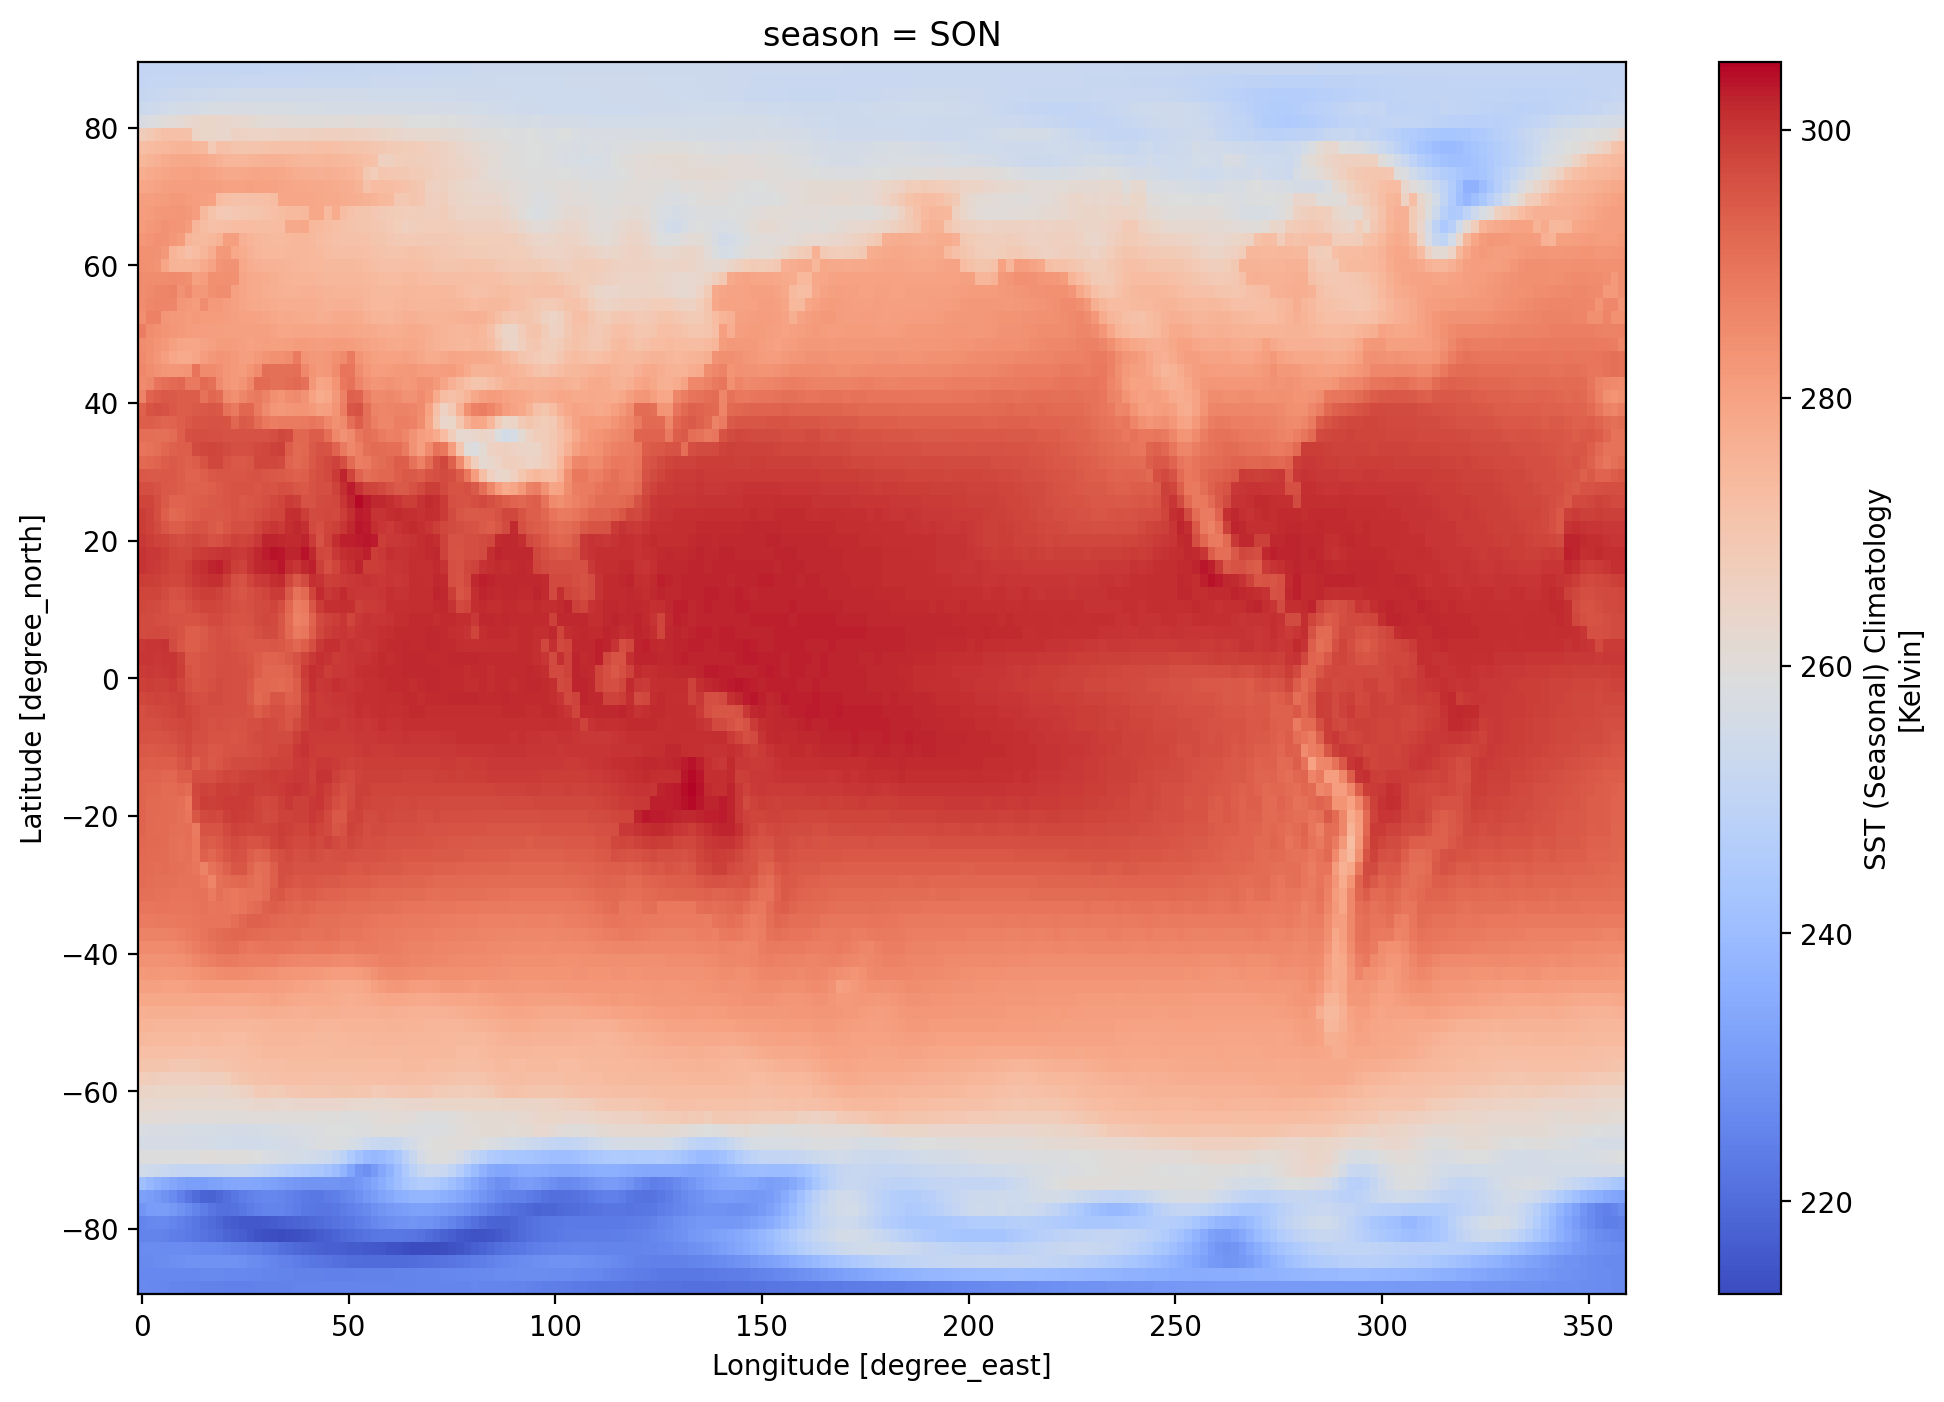

In [59]:
for s in sst_seasons.season.values:
    sst_seasons.climatology.sel(season = s).plot(figsize=(12,8), cmap="coolwarm")

##### Anomaly (time series - weighted mean)

In [68]:
# weight
weight = np.cos(np.deg2rad(sst.lat))
weight.name = "weights"
#weight

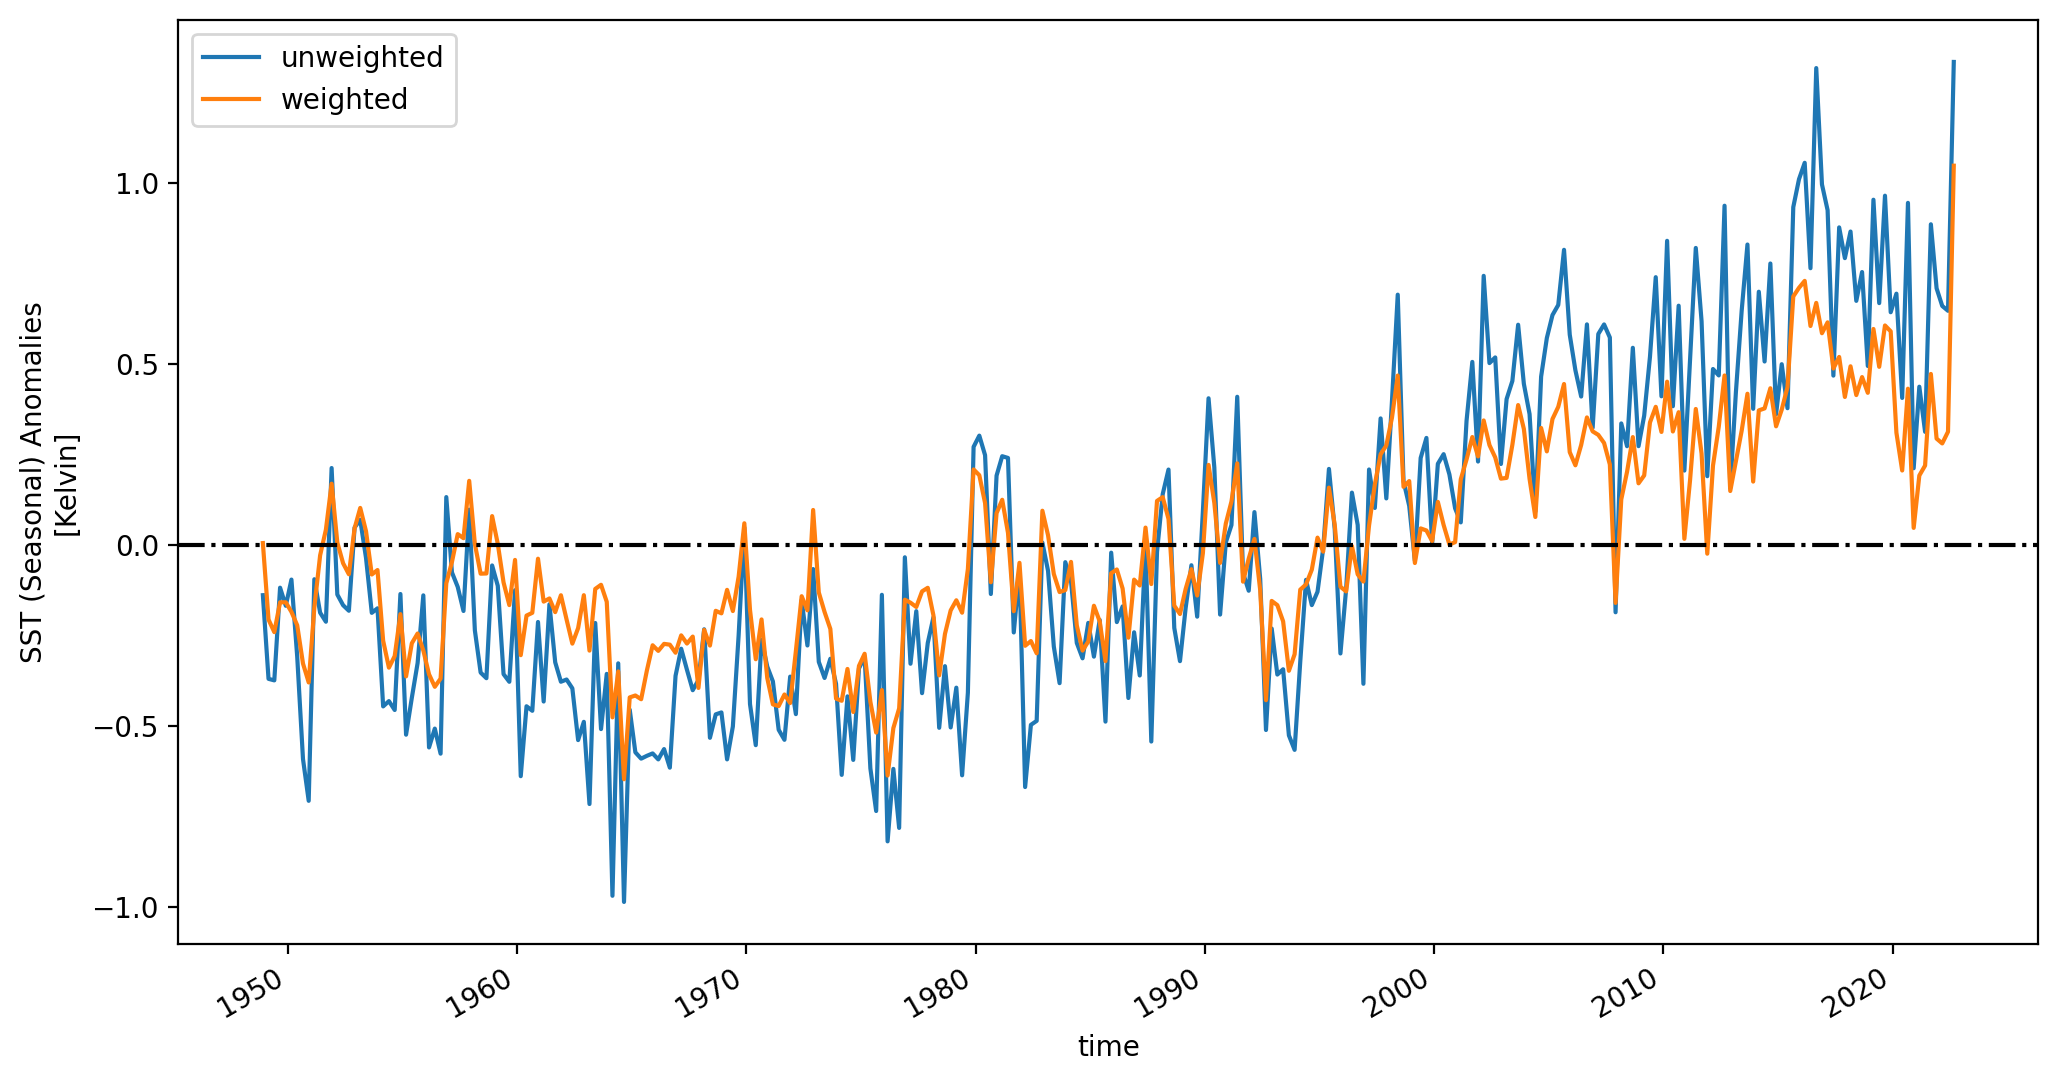

In [67]:
sst_seasons.anomaly.mean(dim=('lat', 'lon'), keep_attrs=True).plot(label='unweighted')
sst_seasons.anomaly.weighted(weight).mean(dim=('lat', 'lon'), keep_attrs=True).plot(label='weighted')
plt.axhline(y=0, color='k', linestyle='-.')
plt.legend()
plt.show()